# 가위바위보 분류기

## 1.1 손모양 데이터 수집
https://teachablemachine.withgoogle.com/ 이 사이트에서 손모양을 찍어서 다운받아서 나의 깃허브에 올렸다.   
손모양 사진   https://github.com/hahacandy/Aiffel_S/tree/main/EXPLORATION_DJ/1.%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B3%BC%20%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4%20%ED%95%98%EA%B8%B0/E1/rock_scissor_paper


## 1.2 하지만 사진이 224x224 사이즈이기때문에 예제에서 나온 28x28 사이즈로 변환


### 파이썬 코드를 사용하기위해 라이브러리들이 좀 필요하다

In [1]:
# PIL 라이브러리가 설치되어 있지 않다면 설치
# pip install pillow   

from PIL import Image
import os, glob
import numpy as np

### 나의 경우에는 폴더 경로가 바껴서 예제와는 조금 다르다

In [12]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train/"
print("이미지 디렉토리 경로: ", image_dir_path)

# 이미지 갯수를 측정하기 위함
images_nums = 0

# 이미지 사이즈 변환 함수
def changes_size(images, label):
    
    global images_nums
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img,"JPEG")
        
        images_nums += 1
    print(label +  "이미지 resize 완료!")


paper_images=glob.glob(image_dir_path + "paper/*.jpg")  
rock_images=glob.glob(image_dir_path + "rock/*.jpg")  
scissor_images=glob.glob(image_dir_path + "scissor/*.jpg")  

changes_size(paper_images, "보")
changes_size(rock_images, "바위")
changes_size(scissor_images, "가위")

이미지 디렉토리 경로:  /home/aiffel/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train/
보이미지 resize 완료!
바위이미지 resize 완료!
가위이미지 resize 완료!


## 2.1 저장된 사진을 훈련데이터로 불러오기

### 저장된 사진을 트레인 행렬에 담는다

In [13]:
def load_data(img_path):
    print(img_path)
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=images_nums   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터의 이미지 개수는",idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

/home/aiffel/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train
학습데이터의 이미지 개수는 9300 입니다.
x_train shape: (9300, 28, 28, 3)
y_train shape: (9300,)


### 잘 불러졌는지 코드를 통해 확인해본다

라벨:  0


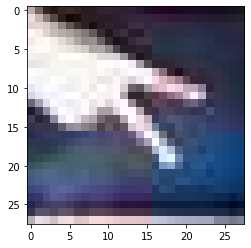

In [14]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
# print('값: ', x_train[0])
print('라벨: ', y_train[0])

画質が悪くてあれは一体何だろうなぐらいのレベル

## 3.1 딥러닝 네트워크 설계하기

### 학원에서 나오는 딥러닝 설계 코드를 그대로 가져왔다   
솔직히 아직 저것들의 원리를 잘 모르기에 일단은 이렇게 하는게 효율이 제일 좋을꺼라 생각함

In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

#바꿔 볼 수 있는 하이퍼파라미터들

n_channel_1=24 # 얼마나 다양한 이미지의 특징을 살펴볼 것인가?(입력 이미지가 다양할수록 더 많은 특징을 고려해보자.)
n_channel_2=48

n_dense=48 # 분류기 알고리즘을 얼마나 복잡하게 할 것인가?(복잡한 문제일수록 이 수를 늘려보자.)
n_dense2=3 # 최종 분류기의 class 수

n_train_epoch=20 # 몇회학습

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3))) # input_shape=(28,28,3) 입력이미지의 형태
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(n_dense2, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

Model에 추가된 Layer 개수:  7
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 24)        672       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 48)        10416     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 48)                57648     
_________________________________________________________________
dense_9 (Dense)              (

## 4 딥러닝 네트워크 학습시키기

### 4.1 학습을 시키기전에 학습이 된 데이터가 담겨질 행렬을 만든다

In [37]:
print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))

Before Reshape - x_train_norm shape: (9300, 28, 28, 3)
After Reshape - x_train_reshaped shape: (9300, 28, 28, 3)


### 4.2 모델을 이용해 학습을 시킨다

In [38]:
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

Epoch 1/20
291/291 [==============================] - 3s 12ms/step - loss: 0.9305 - accuracy: 0.5294
Epoch 2/20
291/291 [==============================] - 0s 1ms/step - loss: 0.5463 - accuracy: 0.7738
Epoch 3/20
291/291 [==============================] - 0s 1ms/step - loss: 0.3425 - accuracy: 0.8709
Epoch 4/20
291/291 [==============================] - 0s 1ms/step - loss: 0.2312 - accuracy: 0.9176
Epoch 5/20
291/291 [==============================] - 0s 1ms/step - loss: 0.1696 - accuracy: 0.9423
Epoch 6/20
291/291 [==============================] - 0s 1ms/step - loss: 0.1231 - accuracy: 0.9632
Epoch 7/20
291/291 [==============================] - 0s 1ms/step - loss: 0.0857 - accuracy: 0.9744
Epoch 8/20
291/291 [==============================] - 0s 1ms/step - loss: 0.0738 - accuracy: 0.9777
Epoch 9/20
291/291 [==============================] - 0s 1ms/step - loss: 0.0534 - accuracy: 0.9854
Epoch 10/20
291/291 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.990

## 5 얼마나 잘 만들었는지 확인하기(테스트)

### 5.1 다른사람들 파일을 다운받아오니 파일 명이 0에서 시작돼서 겹치는 부분이 있어서 파일명을 한번에 바꿔줘야 할 필요가 있음

In [163]:
import os
import shutil

def change_names(_file_path, _folder_name, _start_num, _storge): # start_num 숫자 몇부터 시작해서 이름이 바뀔것인가
    _file_path = _file_path + _folder_name
    file_names = os.listdir(_file_path)
    for name in file_names:
        src = os.path.join(_file_path, name)
        dst = str(_start_num) + '.jpg'
        dst = os.path.join(_file_path, dst)
       
        try:
            os.rename(src, dst)
        except:
            pass
        
        try:
            os.remove(_storge + _folder_name + '/' + str(_start_num) + '.jpg')
        except:
            pass
        
        try:
            shutil.move(dst, _storge + _folder_name) # 그리고 모아두는 폴더로 이동시킴
        except:
            pass
        _start_num += 1
        

folder_num = 4
        
# 사진 이름을 변경할 폴더
file_path = os.getenv("HOME") + '/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train/' + str(folder_num) + '/'

# 이름 변경된 파일들을 특정폴더로 이동시킨다, 그 경로
storge = os.getenv("HOME") + '/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/train/'

start_num = 100*folder_num # start_num 숫자 몇부터 시작해서 이름이 바뀔것인가
change_names(file_path, 'paper', start_num, storge)
change_names(file_path, 'rock', start_num, storge)
change_names(file_path, 'scissor', start_num, storge)

print('완료!')

완료!


### 5.2 테스트하기전에 테스트 할 이미지들을 불러오고 그 데이터를 전처리한다

In [49]:
# 이미지 갯수를 측정하기 위함
images_nums = 300

image_dir_path = os.getenv("HOME") + "/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/test/"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))



print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)  # 데이터갯수에 -1을 쓰면 reshape시 자동계산됩니다.
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))

/home/aiffel/GitHub/Aiffel_S/EXPLORATION_DJ/1.Rock_Paper_Scissors/jupyter/rock_scissor_paper/test/
학습데이터의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
Before Reshape - x_test_norm shape: (300, 28, 28, 3)
After Reshape - x_test_reshaped shape: (300, 28, 28, 3)


# 6 성능 테스트

## 6.1 학습한 데이터를 가지고 테스트 데이터로 성능 테스트를 해본다

In [50]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.0269 - accuracy: 0.9967
test_loss: 0.0269171055406332 
test_accuracy: 0.996666669845581


## 6.2 뭐가 틀렸는지 본다

예측확률분포: [0.32694522 0.25621292 0.4168418 ]
라벨: 0, 예측결과: 2


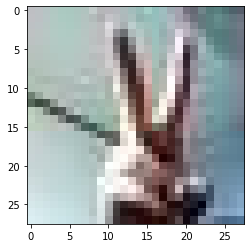

예측확률분포: [0.34733084 0.23648569 0.41618347]
라벨: 0, 예측결과: 2


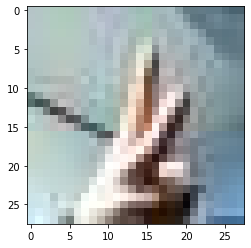

예측확률분포: [0.37346402 0.22544293 0.40109307]
라벨: 0, 예측결과: 2


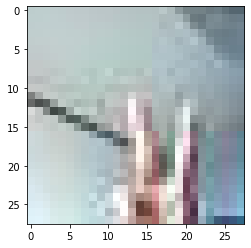

예측확률분포: [0.40458435 0.20139569 0.39402   ]
라벨: 2, 예측결과: 0


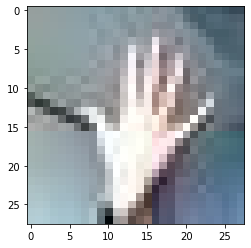

예측확률분포: [0.30752173 0.25494334 0.437535  ]
라벨: 1, 예측결과: 2


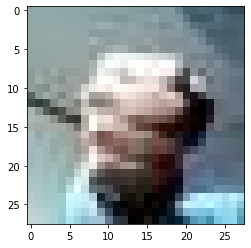

In [169]:
import random

predicted_result = model.predict(x_test_reshaped)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)


wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()